In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los datos desde el archivo CSV
file_path = "../data/raw/excel1.csv"
df = pd.read_csv(file_path, sep=',')

# Convertir la columna ID_Date a formato de fecha (YYYY-MM-DD)
df['ID_Date'] = pd.to_datetime(df['ID_Date'], format='%Y%m').dt.strftime('%Y-%m-%d')
# Mostrar el DataFrame
df.head()

,ID_Date,Unique_visitors,PDFBrochuresDownloaded,ProductConfigurator,Product_configurator_Visists,SocialNetworks,DirectTraffic,EMail,NaturalSearch,OnlineMedia,OtherReferrer,PaidSearch
0,2022-01-01,272382,4838,33222,94248,1415,65373,25,167199,63649,39808,13798
1,2022-02-01,352581,5823,38570,109531,546,77209,26,176733,124861,45543,28656
2,2022-03-01,332955,4845,33956,97805,5444,83178,341,173514,104132,43583,15243
3,2022-04-01,282169,3711,45949,90689,1184,69335,162,162805,74044,39650,18510
4,2022-05-01,261829,9037,48685,92069,8648,70972,210,156011,44196,40472,20031


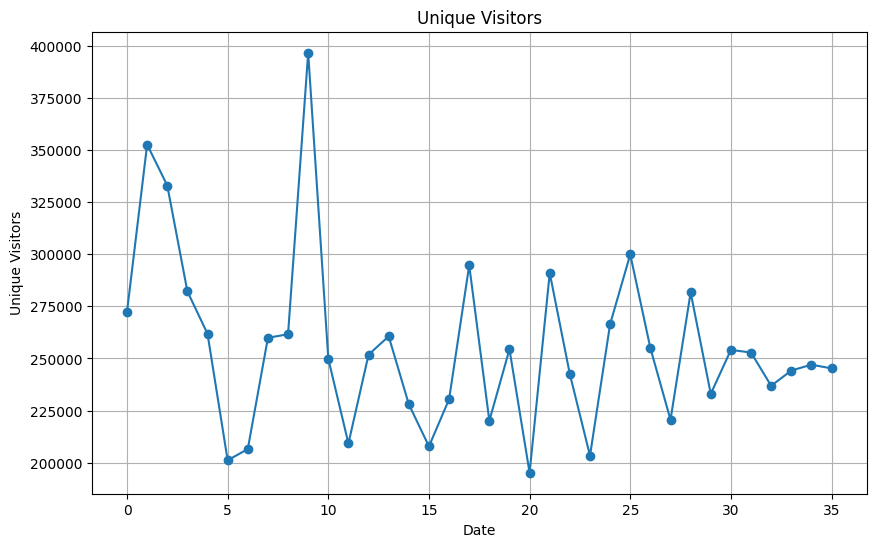

In [2]:
# Graficar la columna 'Revenue'
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Unique_visitors'], marker='o', linestyle='-')
plt.title('Unique Visitors')
plt.xlabel('Date')
plt.ylabel('Unique Visitors')
plt.grid(True)
plt.show()

In [3]:
import numpy as np
print(np.__version__)

1.23.5


In [4]:
# Dividir los datos en conjunto de entrenamiento y conjunto de prueba (80% entrenamiento, 20% prueba)
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Ajustar el modelo SARIMA automáticamente
import pandas as pd
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")


In [5]:
from pmdarima import auto_arima
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt

# 1. Preprocesamiento sin transformación logarítmica
y = df["Unique_visitors"]  # Usamos los valores originales
X = df[['SocialNetworks', 'PaidSearch']]  # Variables exógenas clave

In [ ]:
# 2. División train-test (80%-20%)
train_size = int(len(df) * 0.8)
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]

# 3. Escalado (solo con train)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), 
                   columns=X_train.columns, 
                   index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test),
                  columns=X_test.columns,
                  index=X_test.index)

# 4. Búsqueda del modelo (sin log)
model = auto_arima(
    y_train,  # Usamos y_train original
    exogenous=X_train_scaled,
    seasonal=True,
    m=12,
    d=1,  # Diferenciación no estacional fija
    D=1,  # Diferenciación estacional fija
    
    start_P=0, max_P=3,
    start_p=0, max_p=3,
    start_q=0, max_q=3,
    start_Q=0, max_Q=3,
    stepwise=False,     # Para exploración exhaustiva (más lento)
    trace=True,
    suppress_warnings=True,  # Para ver posibles problemas
    error_action='ignore',      # Cambiado de 'ignore' a 'warn'
    information_criterion='aic')
print('Mejor modelo encontrado:', model.get_params())

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=375.300, Time=0.01 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=367.872, Time=0.06 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=369.479, Time=0.21 sec
 ARIMA(0,1,0)(0,1,3)[12]             : AIC=370.921, Time=0.34 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=368.040, Time=0.19 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=369.858, Time=0.08 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=371.430, Time=0.27 sec
 ARIMA(0,1,0)(1,1,3)[12]             : AIC=372.844, Time=0.42 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=370.067, Time=0.10 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=371.599, Time=0.19 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=373.181, Time=0.33 sec
 ARIMA(0,1,0)(2,1,3)[12]             : AIC=374.807, Time=0.73 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=372.067, Time=0.18 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=373.599, Time=0.48 sec
 ARIMA(0,1,0)(3,1,2)[12]             : AIC=375.181, Time=0.74 sec
 ARIMA(0,1

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                   28
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -181.936
Date:                              Sun, 06 Apr 2025   AIC                            367.872
Time:                                      16:40:53   BIC                            369.289
Sample:                                           0   HQIC                           367.857
                                               - 28                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.5651      0.624     -0.906      0.365      -1.788       0.658
sigma2      2.915e+

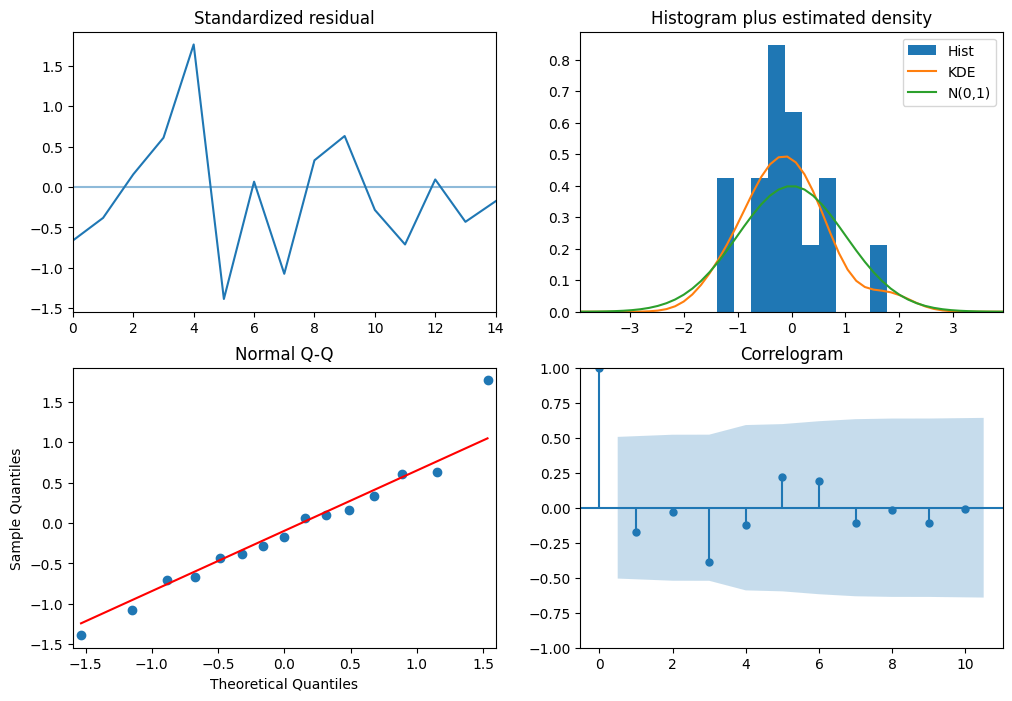

In [7]:

# 5. Predicción (directamente en escala original)
preds = model.predict(n_periods=12, exogenous=X_test_scaled)

# 6. Resultados
print(model.summary())

# Diagnóstico
model.plot_diagnostics(figsize=(12,8))
plt.show()

## Ajuste Manual de Parámetro `p` en Modelado SARIMA

Durante el proceso de ajuste automático del modelo SARIMA mediante `auto_arima`, observamos que el mejor modelo según el **criterio AIC** fue:
ARIMA(0,1,0)(0,1,1)[12]



Este modelo fue seleccionado automáticamente por tener el menor AIC, pero presentaba una **limitación importante en la capacidad de capturar ciertos patrones** en los datos históricos, especialmente en los **"picos" o cambios bruscos** del valor objetivo (posiblemente debido a shocks externos o estacionalidades no lineales).

### ¿Por qué `p=0` no era suficiente?

El parámetro `p` representa el número de retardos en la parte **autorregresiva (AR)** del modelo. Un valor de `p=0` implica que el modelo **no considera los valores pasados inmediatos** para predecir el valor actual. Esto puede resultar en una pérdida de capacidad para capturar:

- Efectos de memoria de corto plazo.
- Reversiones rápidas a la media.
- Picos o caídas repentinas que tienden a replicarse temporalmente.

### Ajuste Manual: Fijar `p=1`

Para mejorar el ajuste en estos casos, decidimos **fijar `p=1` manualmente**, lo cual permite que el modelo tenga en cuenta el valor inmediato anterior (lag-1). Esto proporciona al modelo una mayor flexibilidad para:

- Seguir mejor los picos y valles del comportamiento de la serie.
- Capturar relaciones de corto plazo que el modelo original ignoraba.
- Ajustarse más naturalmente a los ciclos recientes en los datos.

### Resultado

Con `p=1`, el modelo obtuvo un ajuste visualmente más consistente en los últimos 60 meses y una predicción más realista sobre los siguientes 20 periodos.

---

Este ajuste demuestra que, si bien el modelo automático basado en AIC es útil como punto de partida, **la validación visual y el juicio experto** siguen siendo clave para construir un modelo robusto y útil en la práctica.


                                      SARIMAX Results                                       
Dep. Variable:                      Unique_visitors   No. Observations:                   28
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -181.998
Date:                              Sun, 06 Apr 2025   AIC                            369.996
Time:                                      16:46:22   BIC                            372.120
Sample:                                           0   HQIC                           369.973
                                               - 28                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0105      0.342      0.031      0.976      -0.659       0.680
ma.S.L12      -0.55

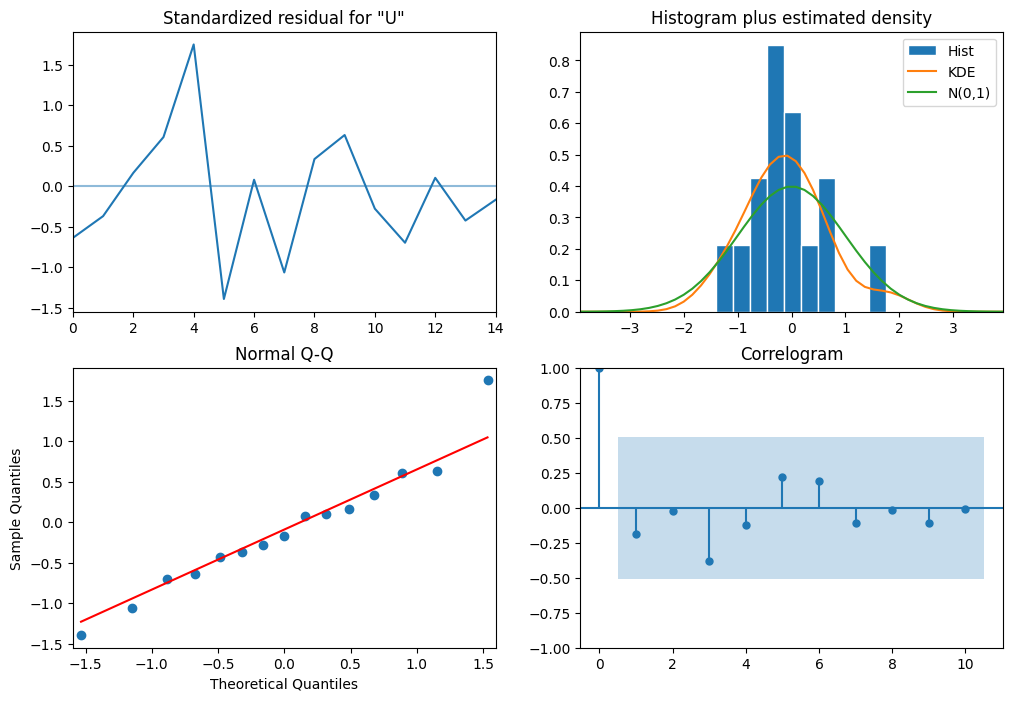

In [15]:
from statsmodels.tsa.api import SARIMAX
import matplotlib.pyplot as plt

# 1. Ajustar el modelo a los datos de entrenamiento
sarima_model2 = SARIMAX(train['Unique_visitors'], 
                        order=(1, 1, 0), 
                        seasonal_order=(0, 1, 1, 12))
sarima_result = sarima_model2.fit()

# 6. Resultados
print(sarima_result.summary())

# 7. Diagnóstico
sarima_result.plot_diagnostics(figsize=(12,8))
plt.show()

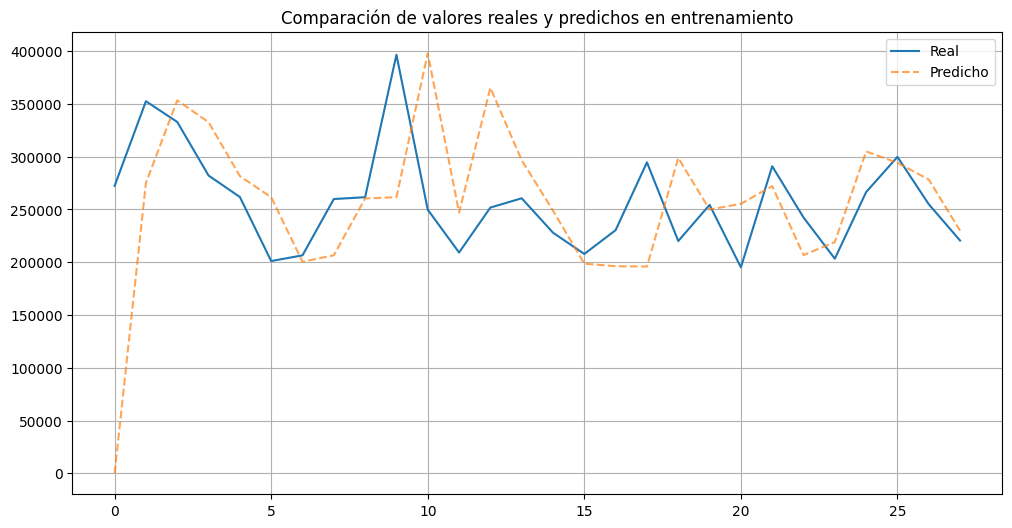

In [14]:

# 4. Predicciones en el conjunto de entrenamiento para ver ajuste
# Usamos dynamic=False para que use los valores reales como historia inicial
train['predicted'] = sarima_result.predict(start=train.index[0], end=train.index[-1], dynamic=False)

# 5. Gráfico de valores reales vs predichos
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Unique_visitors'], label='Real')  # Especificamos los índices en el plot
plt.plot(train.index, train['predicted'], label='Predicho', alpha=0.7, linestyle='--')
plt.legend()
plt.title('Comparación de valores reales y predichos en entrenamiento')
plt.grid(True)
plt.show()
plt.show()

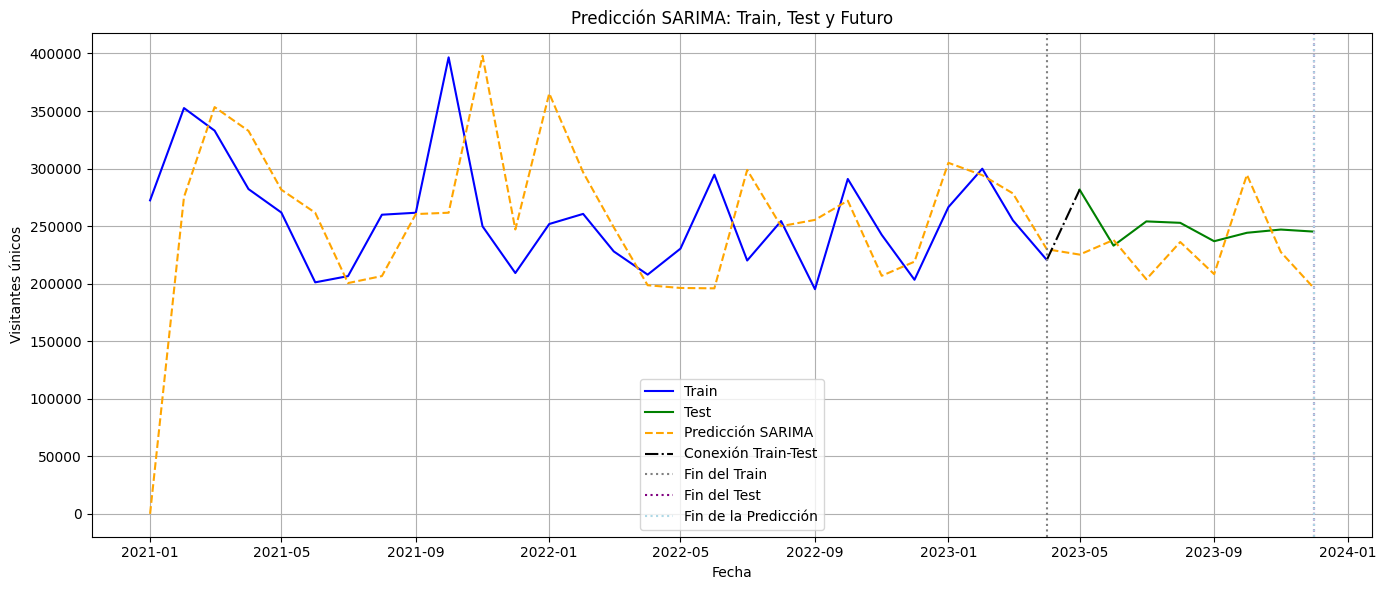

In [23]:
# 1. Predicción desde el inicio hasta 6 meses más allá del test
start_index = 0
end_index = 35  # 36 (último del test) + 6 meses futuros

# 2. Predicción SARIMA (usa datos reales, no dinámica)
full_prediction = sarima_result.predict(start=start_index, end=end_index, dynamic=False)

# 3. Crear índice de fechas correcto (iniciando en enero 2021, ajusta si usas otro inicio)
prediction_index = pd.date_range(start='2021-01-01', periods=len(full_prediction), freq='MS')

# 4. DataFrame con predicción y fechas correctas
prediction_df = pd.DataFrame({'predicted': full_prediction})
prediction_df.index = prediction_index  # Muy importante: usar el índice de fechas

# 5. Reasignar fechas a train y test
date_index = pd.date_range(start='2021-01-01', periods=36, freq='MS')  # train (0-24) + test (25-35)
train.index = date_index[:len(train)]
test.index = date_index[len(train):]

# 6. Gráfico completo
plt.figure(figsize=(14, 6))

# Datos reales: train y test
plt.plot(train.index, train['Unique_visitors'], label='Train', color='blue')
plt.plot(test.index, test['Unique_visitors'], label='Test', color='green')

# Predicción SARIMA completa
plt.plot(prediction_df.index, prediction_df['predicted'], label='Predicción SARIMA', color='orange', linestyle='--')

# Línea conectando fin de train con inicio de test
plt.plot(
    [train.index[-1], test.index[0]],
    [train['Unique_visitors'].iloc[-1], test['Unique_visitors'].iloc[0]],
    color='black',
    linestyle='-.',
    label='Conexión Train-Test'
)

# Líneas verticales para separar zonas
plt.axvline(x=train.index[-1], color='gray', linestyle=':', label='Fin del Train')
plt.axvline(x=test.index[-1], color='purple', linestyle=':', label='Fin del Test')
plt.axvline(x=prediction_df.index[-1], color='lightblue', linestyle=':', label='Fin de la Predicción')

plt.title('Predicción SARIMA: Train, Test y Futuro')
plt.xlabel('Fecha')
plt.ylabel('Visitantes únicos')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


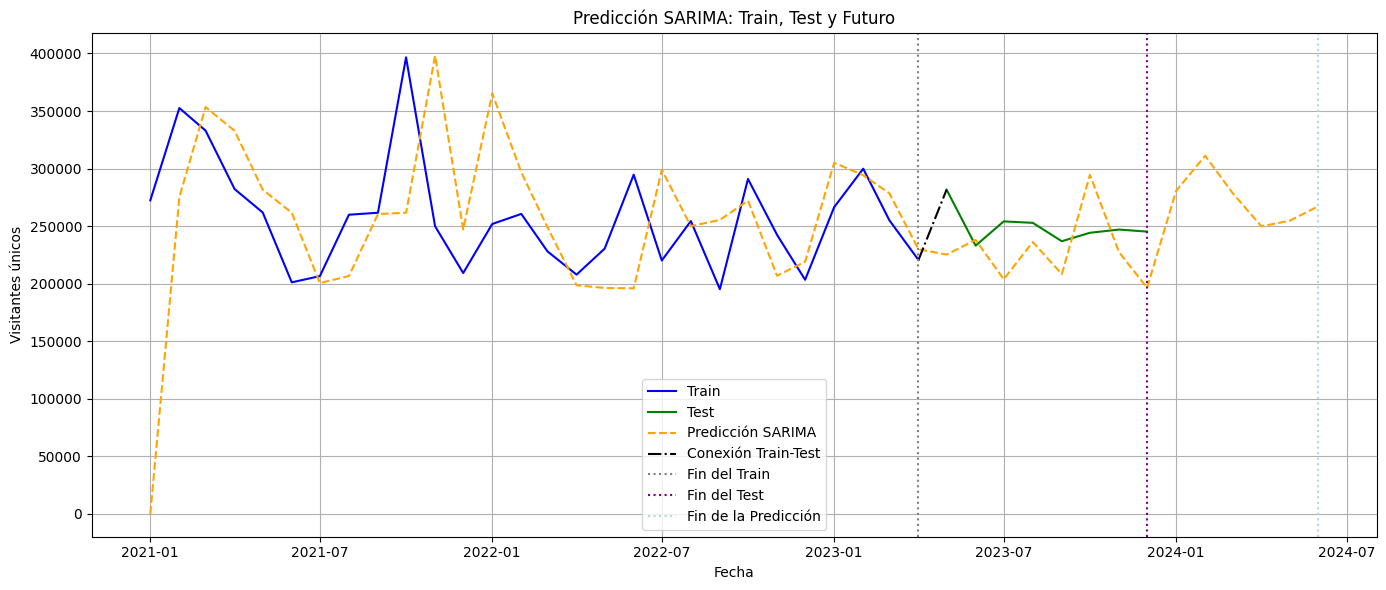

In [22]:
# 1. Predicción desde el inicio hasta 6 meses más allá del test
start_index = 0
end_index = 41  # 36 (último del test) + 6 meses futuros

# 2. Predicción SARIMA (usa datos reales, no dinámica)
full_prediction = sarima_result.predict(start=start_index, end=end_index, dynamic=False)

# 3. Crear índice de fechas correcto (iniciando en enero 2021, ajusta si usas otro inicio)
prediction_index = pd.date_range(start='2021-01-01', periods=len(full_prediction), freq='MS')

# 4. DataFrame con predicción y fechas correctas
prediction_df = pd.DataFrame({'predicted': full_prediction})
prediction_df.index = prediction_index  # Muy importante: usar el índice de fechas

# 5. Reasignar fechas a train y test
date_index = pd.date_range(start='2021-01-01', periods=36, freq='MS')  # train (0-24) + test (25-35)
train.index = date_index[:len(train)]
test.index = date_index[len(train):]

# 6. Gráfico completo
plt.figure(figsize=(14, 6))

# Datos reales: train y test
plt.plot(train.index, train['Unique_visitors'], label='Train', color='blue')
plt.plot(test.index, test['Unique_visitors'], label='Test', color='green')

# Predicción SARIMA completa
plt.plot(prediction_df.index, prediction_df['predicted'], label='Predicción SARIMA', color='orange', linestyle='--')

# Línea conectando fin de train con inicio de test
plt.plot(
    [train.index[-1], test.index[0]],
    [train['Unique_visitors'].iloc[-1], test['Unique_visitors'].iloc[0]],
    color='black',
    linestyle='-.',
    label='Conexión Train-Test'
)

# Líneas verticales para separar zonas
plt.axvline(x=train.index[-1], color='gray', linestyle=':', label='Fin del Train')
plt.axvline(x=test.index[-1], color='purple', linestyle=':', label='Fin del Test')
plt.axvline(x=prediction_df.index[-1], color='lightblue', linestyle=':', label='Fin de la Predicción')

plt.title('Predicción SARIMA: Train, Test y Futuro')
plt.xlabel('Fecha')
plt.ylabel('Visitantes únicos')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


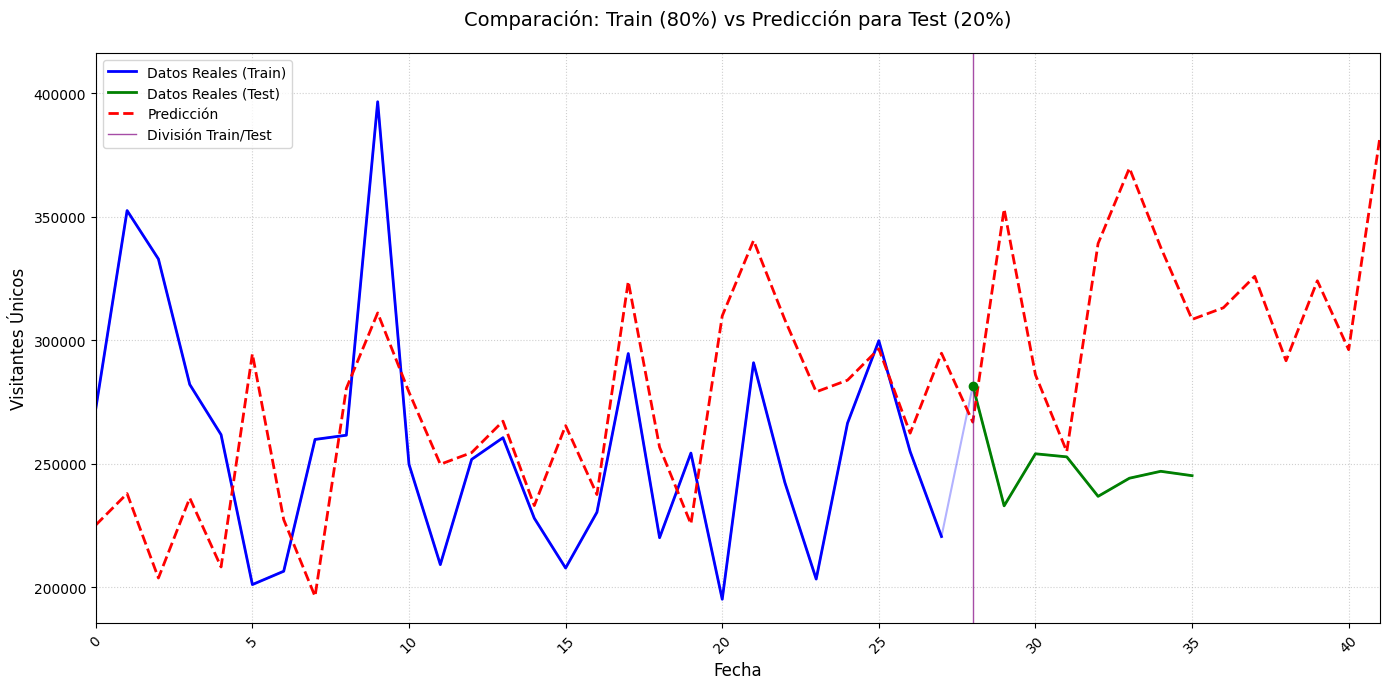

In [ ]:
# 3. Predecir sobre el conjunto test (20% final) con intervalo de confianza
forecast = sarima_result.get_forecast(steps=len(df)+6, alpha=0.05)  # 95% IC
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# 4. Crear gráfico con transición suave
plt.figure(figsize=(14, 7))

# Primero graficar TODOS los datos reales en azul (fondo)
plt.plot(df.index, df['Unique_visitors'], 
         color='blue', 
         alpha=0.3, 
         label='_nolegend_')  # Oculta de la leyenda

# Luego graficar solo TRAIN (80%) con línea sólida
plt.plot(train.index, train['Unique_visitors'], 
         label='Datos Reales (Train)', 
         color='blue',
         linewidth=2)

# Superponer TEST (20%) en verde
plt.plot(test.index, test['Unique_visitors'], 
         label='Datos Reales (Test)', 
         color='green',
         linewidth=2)

# Añadir punto de conexión para unión perfecta
plt.scatter(test.index[0], test['Unique_visitors'].iloc[0],
           color='green', 
           zorder=5,
           label='_nolegend_')

# Predicción y IC
plt.plot(range(42), forecast_mean, 
         label='Predicción', 
         color='red', 
         linestyle='--',
         linewidth=2)


# Línea divisoria con estilo mejorado
plt.axvline(x=test.index[0], 
            color='purple', 
            linestyle='-', 
            linewidth=1,
            alpha=0.7,
            label='División Train/Test')

# Configuración mejorada
plt.title('Comparación: Train (80%) vs Predicción para Test (20%)', fontsize=14, pad=20)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Visitantes Únicos', fontsize=12)
plt.legend(loc='upper left', fontsize=10)
plt.grid(True, linestyle=':', alpha=0.6)

# Ajustar ejes para mejor visualización
plt.xlim([df.index[0], df.index[-1]+6])
plt.ylim([df['Unique_visitors'].min()*0.95, df['Unique_visitors'].max()*1.05])

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import yfinance as yf
data = yf.download("AAPL", start="2010-01-01", end="2025-04-04")  # Datos de Apple
data.tail()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2025-03-28,217.899994,223.809998,217.679993,221.669998,39818600
2025-03-31,222.130005,225.619995,216.229996,217.009995,65299300
2025-04-01,223.190002,223.679993,218.899994,219.809998,36412700
2025-04-02,223.889999,225.190002,221.020004,221.320007,35905900
2025-04-03,203.190002,207.490005,201.250000,205.539993,103204700


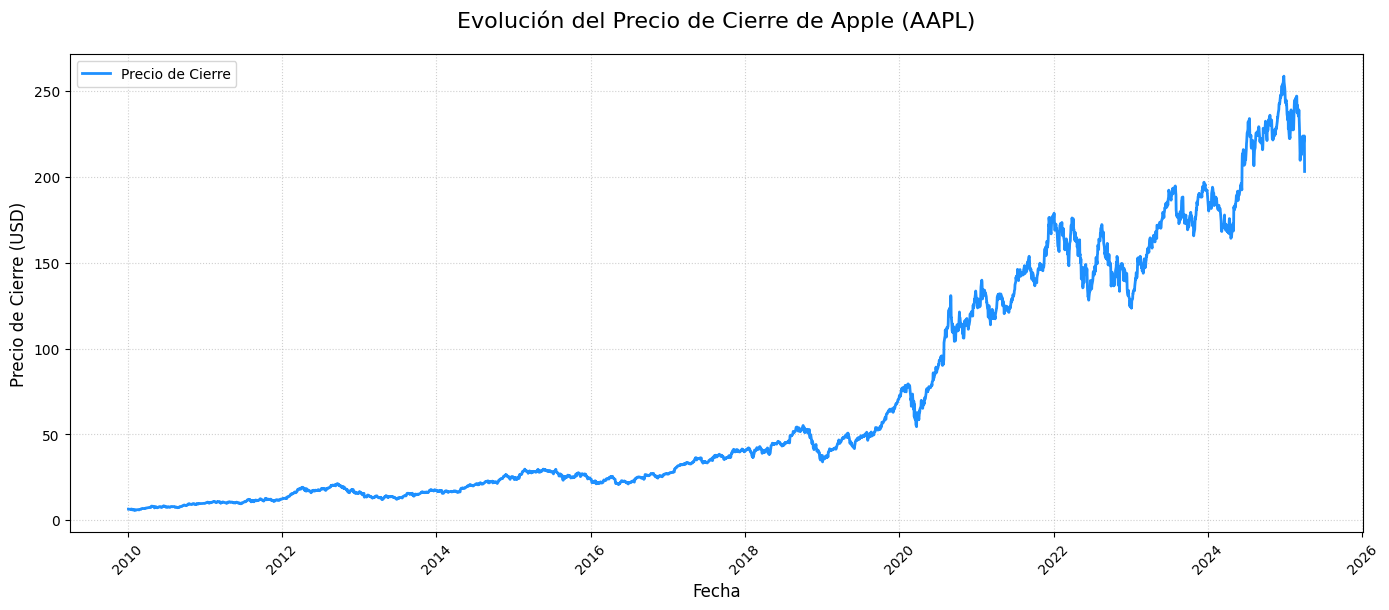

In [ ]:
# Crear gráfico de cierre
plt.figure(figsize=(14, 6))
plt.plot(data.index, data['Close'], color='dodgerblue', linewidth=2, label='Precio de Cierre')

# Estética y configuraciones
plt.title("Evolución del Precio de Cierre de Apple (AAPL)", fontsize=16, pad=20)
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Precio de Cierre (USD)", fontsize=12)
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


In [ ]:

# Entrenar modelo auto_arima
stepwise_model = auto_arima(data['Close'],
                             start_p=1, start_q=1,
                             max_p=5, max_q=5,
                             start_P=0, seasonal=True,
                             d=None, D=None, max_d=2, max_D=2,
                             m=5,  # Frecuencia estacional (puedes ajustar a 12 si es mensual)
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True)

# Mostrar resumen del mejor modelo encontrado
stepwise_model.summary()


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[5] intercept   : AIC=14905.866, Time=2.13 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=14903.494, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=14906.456, Time=0.22 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=14906.388, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=14905.037, Time=0.05 sec
 ARIMA(0,1,0)(1,0,0)[5] intercept   : AIC=14904.713, Time=0.19 sec
 ARIMA(0,1,0)(0,0,1)[5] intercept   : AIC=14904.649, Time=0.15 sec
 ARIMA(0,1,0)(1,0,1)[5] intercept   : AIC=14900.481, Time=0.93 sec
 ARIMA(0,1,0)(2,0,1)[5] intercept   : AIC=inf, Time=3.12 sec
 ARIMA(0,1,0)(1,0,2)[5] intercept   : AIC=inf, Time=2.62 sec
 ARIMA(0,1,0)(0,0,2)[5] intercept   : AIC=14901.295, Time=0.28 sec
 ARIMA(0,1,0)(2,0,0)[5] intercept   : AIC=14901.343, Time=0.39 sec
 ARIMA(0,1,0)(2,0,2)[5] intercept   : AIC=inf, Time=3.13 sec
 ARIMA(1,1,0)(1,0,1)[5] intercept   : AIC=14902.292, Time=1.08 sec
 ARIMA(0,1,1)(1,0,1)[5] intercept   :

In [ ]:
print(stepwise_model.summary())


                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 3837
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 5)   Log Likelihood               -7446.240
Date:                             Fri, 04 Apr 2025   AIC                          14900.481
Time:                                     17:55:43   BIC                          14925.490
Sample:                                          0   HQIC                         14909.365
                                            - 3837                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0944      0.051      1.834      0.067      -0.006       0.195
ar.S.L5       -0.8427      

In [ ]:
from pmdarima import auto_arima


# Búsqueda automática del mejor modelo (elimina el guesswork)
auto_model = auto_arima(
    train['Unique_visitors'],
    seasonal=True,
    d=1,  # Diferenciación no estacional fija
    D=1,  # Diferenciación estacional fija
    m=12,  # Frecuencia estacional (mensual)
    trace=True,  # Muestra progreso
    stepwise=True,  # Método eficiente
    suppress_warnings=True
)

print(auto_model.summary())

In [ ]:

sarima_fit2 = sarima_model2.fit()

sarima_predictions2 = sarima_fit2.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')

sarima_residuals2 = test['Unique_visitors'] - sarima_predictions2

# Crear un DataFrame para los residuos
residuals_df = pd.DataFrame({
    'Fecha': test.index,
   
    'SARIMA (0, 1, 0)(1, 0, 1, 12) Residuos': sarima_residuals2
})

# Mostrar la tabla de resultados
print(residuals_df)

In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Cargar datos de visitas (excel3)
visitas = pd.read_csv('../data/raw/excel3.csv')
visitas['ID_Date'] = pd.to_datetime(visitas['ID_Date'], format='%Y%m')
visitas.set_index('ID_Date', inplace=True)

# Cargar datos de marketing (excel5) para variables exógenas
marketing = pd.read_csv('../data/raw/excel5.csv')
marketing['ID_Date'] = pd.to_datetime(marketing['ID_Date'], format='%Y%m')
marketing.set_index('ID_Date', inplace=True)

# Combinar datasets
df = visitas.join(marketing[['INTERNET', 'INV_Total']])

# Modelo ARIMAX
model = ARIMA(df['Visit_Store'],
              exog=df[['INTERNET']],
              order=(1,1,1))  # Ajustar parámetros
results = model.fit()

# Predicción
future_periods = 12  # Predecir 12 meses
future_exog = df[['INTERNET']][-future_periods:]  # Datos futuros de marketing

forecast = results.get_forecast(steps=future_periods, exog=future_exog)
forecast_ci = forecast.conf_int()

# Visualización
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Visit_Store'], label='Observado')
plt.plot(forecast.predicted_mean.index, forecast.predicted_mean, color='r', label='Predicción')
plt.fill_between(forecast_ci.index,
                forecast_ci.iloc[:,0],
                forecast_ci.iloc[:,1], color='pink')
plt.title('Predicción de Visitantes Únicos')
plt.legend()
plt.show()